# 1. Amazon SageMaker トレーニング用の PotentialNet Graph バイナリファイルの作成

## 概要

このノートブックでは、PDBBind複合体データからグラフバイナリファイルを構築します。各PDB IDから2つのバイナリファイルが作成されます。それぞれのグラフバイナリには、リガンドとポケットの複合体を表すバイグラフ(bigraph)が含まれています。2つのバイナリファイルの違いは、片方のバイグラフはPotentialNetの学習ステージ1に使用され、もう片方は学習ステージ2に使用されることです。

* まず、PDBBindのデータセット(PDBBind v2020)をPDBBindのウェブサイトからダウンロードします。
* 次に、ligandファイル（.sdf）とpoketファイル（.pdb）からグラフデータを抽出し、バイナリファイルを作成します。
* 最後に、バイナリファイルを4つのグループ（train, validation, test, and additional holdout (i.e. fine-tuning)）に分割しています。また、分割の指示を記述したCSVファイルを作成します。

## Dataset : PDBBind v2020

http://www.pdbbind.org.cn/ から以下の3つのアーカイブファイルをダウンロードします。
* CASF-2016.tar.gz (PDBBind v2020のコアファイル)
* PDBbind_v2020_refined.tar.gz (PDBBind v2020のリファイン版ファイル)
* PDBbind_v2020_other_PL.tar.gz (PDBBind v2020 のその他のファイル)

この例では、これらのアーカイブファイルは既にS3にアップロードされています。S3からローカルディレクトリ(./data)にダウンロードすることにします

In [2]:
!pip install dgl dgllife biopython seaborn transformers rdkit-pypi

  Using cached dgllife-0.3.0-py3-none-any.whl (220 kB)
  Using cached biopython-1.79-cp36-cp36m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (2.3 MB)
  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Using cached transformers-4.18.0-py3-none-any.whl (4.0 MB)
  Using cached rdkit_pypi-2021.9.4-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (20.6 MB)
  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
  Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
  Using cached filelock-3.4.1-py3-none-any.whl (9.9 kB)
  Using cached huggingface_hub-0.4.0-py3-none-any.whl (67 kB)
  Using cached tokenizers-0.12.1-cp36-cp36m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (6.6 MB)
  Using cached regex-2022.10.31-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (756 kB)
  Using cached sacremoses-0.0.53-py3-none-any.whl
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)
  Using cached cloudpickle-2.2.0-py3-none-any.whl (25 kB)
  Attempting uninstall: dec

In [3]:
import os

data_dir = 'data'
isExist = os.path.exists(data_dir)
    
if not isExist: 
    os.makedirs(data_dir)
    print(f"The new directory {data_dir} is created!") 

### Core Dataset

In [4]:
!wget https://d2125kp0qwrvcx.cloudfront.net/dgl-pdbbind/CASF-2016.tar.gz -P ./{data_dir}
#!aws s3 cp s3://'<your S3 prefix of PDBbind dataset>'/dgl-pdbbind/CASF-2016.tar.gz ./{data_dir}/CASF-2016.tar.gz

--2022-12-15 05:27:12--  https://d2125kp0qwrvcx.cloudfront.net/dgl-pdbbind/CASF-2016.tar.gz
Resolving d2125kp0qwrvcx.cloudfront.net (d2125kp0qwrvcx.cloudfront.net)... 65.8.62.174, 65.8.62.25, 65.8.62.120, ...
Connecting to d2125kp0qwrvcx.cloudfront.net (d2125kp0qwrvcx.cloudfront.net)|65.8.62.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1572660769 (1.5G) [application/x-tar]
Saving to: ‘./data/CASF-2016.tar.gz’

CASF-2016.tar.gz    100%[===================>]   1.46G  18.8MB/s    in 55s     

2022-12-15 05:28:09 (27.1 MB/s) - ‘./data/CASF-2016.tar.gz’ saved [1572660769/1572660769]



### Refined Dataset

In [5]:
!wget https://d2125kp0qwrvcx.cloudfront.net/dgl-pdbbind/PDBbind_v2020_refined.tar.gz -P ./{data_dir}
#!aws s3 cp s3://'<your S3 prefix of PDBbind dataset>'/dgl-pdbbind/PDBbind_v2020_refined.tar.gz ./{data_dir}/PDBbind_v2020_refined.tar.gz

--2022-12-15 05:28:09--  https://d2125kp0qwrvcx.cloudfront.net/dgl-pdbbind/PDBbind_v2020_refined.tar.gz
Resolving d2125kp0qwrvcx.cloudfront.net (d2125kp0qwrvcx.cloudfront.net)... 65.8.62.50, 65.8.62.120, 65.8.62.25, ...
Connecting to d2125kp0qwrvcx.cloudfront.net (d2125kp0qwrvcx.cloudfront.net)|65.8.62.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 690895072 (659M) [application/x-tar]
Saving to: ‘./data/PDBbind_v2020_refined.tar.gz’

PDBbind_v2020_refin 100%[===================>] 658.89M  20.1MB/s    in 24s     

2022-12-15 05:28:34 (27.1 MB/s) - ‘./data/PDBbind_v2020_refined.tar.gz’ saved [690895072/690895072]



### Other Dataset

In [ ]:
#wget https://d2125kp0qwrvcx.cloudfront.net/dgl-pdbbind/PDBbind_v2020_other_PL.tar.gz -P ./{data_dir}
#!aws s3 cp s3://'<your S3 prefix of PDBbind dataset>'/dgl-pdbbind/PDBbind_v2020_other_PL.tar.gz ./{data_dir}/PDBbind_v2020_other_PL.tar.gz

※ 以前、PDBBind データセットはインデックス規則を変更しています。 v2016 と v2020 の間のデータセットは、同様のインデックス規則を共有しています。同様に、v2012 から 2015 までのデータセットは類似しています。

## Setup

This is a example for building a conda environment to run this notebook on Amazon SageMaker notebook instance. 

```
conda create --name dgllife6 --clone pytorch_latest_p36
conda activate dgllife6
conda install -y -c dglteam rdkit==2018.09.3 dgl-cuda10.1==0.7.2
conda list
pip install dgllife==0.2.9
pip install -U ipykernel
pip uninstall -y ipython prompt_toolkit
pip install ipython prompt_toolkit
python -m ipykernel install --user --name dgllife6 --display-name dgllife6
```

## Modules

In [4]:
import random
from functools import partial
from itertools import accumulate

import dgl
import numpy as np
import numpy.random as nrd
import torch
from dgl.data.utils import Subset
from dgllife.data.pdbbind import PDBBind#, PDBBind_v2020
from dgllife.model import ACNN, PotentialNet
from dgllife.utils import (PN_graph_construction_and_featurization,
                           ACNN_graph_construction_and_featurization,#
                           multiprocess_load_molecules)#
# Added
from dgl.data.utils import get_download_dir, download, _get_dgl_url, extract_archive#
import pandas as pd
import glob
import dgl.backend as F
import multiprocessing
import os
import glob
from functools import partial

# Save graph
from dgl.data.utils import save_graphs
from tqdm import tqdm

import dgl.backend as F
from dgl import graph, heterograph, batch
from dgllife.utils.mol_to_graph import k_nearest_neighbors, mol_to_bigraph
from dgllife.utils.featurizers import BaseAtomFeaturizer, BaseBondFeaturizer, ConcatFeaturizer, atom_type_one_hot, atom_total_degree_one_hot, atom_formal_charge_one_hot, atom_is_aromatic, atom_implicit_valence_one_hot, atom_explicit_valence_one_hot, bond_type_one_hot, bond_is_in_ring

torch.multiprocessing.set_sharing_strategy('file_system')

ROOT_DIR = os.getcwd()
print(f'Current working directory : {ROOT_DIR}')

Using backend: pytorch


Current working directory : /root/JP-Graph-Neural-Networks-in-Life-Sciences/Graph-Neural-Networks-in-Life-Sciences/4_bigraph_affinity_prediction


## Helper Functions

In [5]:
class PDBBind_v2020(PDBBind):
    def __init__(self, 
                 subset, 
                 pdb_version='v2015', 
                 load_binding_pocket=True, 
                 remove_coreset_from_refinedset=True, 
                 sanitize=False, 
                 calc_charges=False, 
                 remove_hs=False, 
                 use_conformation=True,
                 construct_graph_and_featurize=ACNN_graph_construction_and_featurization,
                 zero_padding=True, 
                 num_processes=None, 
                 local_path=None,
                 distance_bins=[1.5, 2.5, 3.5, 4.5],
                 save_bin_files=True):
        print(" ")
        print("---Using PDBBind v2020 compatible loader---")
        print(" ")
        
        self.save_bin_files = save_bin_files
        self.pdb_version = pdb_version
        self.subset = subset
        self.distance_bins = distance_bins
        
        super().__init__(subset, 
                         pdb_version, 
                         load_binding_pocket, 
                         remove_coreset_from_refinedset, 
                         sanitize, 
                         calc_charges, 
                         remove_hs, 
                         use_conformation,
                         construct_graph_and_featurize,
                         zero_padding, 
                         num_processes, 
                         local_path)
        
    def _read_data_files(self, pdb_version, subset, load_binding_pocket, remove_coreset_from_refinedset, local_path):
        """Download and extract pdbbind data files specified by the version"""
        root_dir_path = get_download_dir()
        if local_path:
            print(" ")
            print("--Using Local Path--")
            print(" ")
            if local_path[-1] != '/':
                local_path += '/'
            index_label_file = glob.glob(local_path + '*' + subset + '*data*')[0]
            
        elif pdb_version == 'v2015':
            print(" ")
            print("--v2015--")
            print(" ")
            
            self._url = 'dataset/pdbbind_v2015.tar.gz'
            data_path = root_dir_path + '/pdbbind_v2015.tar.gz'
            extracted_data_path = root_dir_path + '/pdbbind_v2015'
            download(_get_dgl_url(self._url), path=data_path, overwrite=False)
            extract_archive(data_path, extracted_data_path)

            if subset == 'core':
                index_label_file = extracted_data_path + '/v2015/INDEX_core_data.2013'
            elif subset == 'refined':
                index_label_file = extracted_data_path + '/v2015/INDEX_refined_data.2015'
            else:
                raise ValueError('Expect the subset_choice to be either core or refined, got {}'.format(subset))
                
        elif pdb_version == 'v2020':
            print(" ")
            print("--v2020--")
            print(" ")
            
            root_dir_path = ROOT_DIR + f'/{data_dir}'
            print(f'root_dir_path : {root_dir_path}')
            
            # Others
            #print("--v2020 other PL--")
            #
            #data_path = root_dir_path + '/PDBbind_v2020_other_PL.tar.gz'
            #print(f'data_path : {data_path}')
            #extracted_data_path = root_dir_path + '/pdbbind_v2020'
            #extract_archive(data_path, extracted_data_path)
            
            # Refined
            print("--v2020 refined--")
            data_path = root_dir_path + '/PDBbind_v2020_refined.tar.gz'
            print(f'data_path : {data_path}')
            extracted_data_path = root_dir_path + '/pdbbind_v2020'
            extract_archive(data_path, extracted_data_path, overwrite=True)

            #index_label_file = extracted_data_path + '/v2020-other-PL/index/INDEX_general_PL_data.2020'
            if subset == 'core':
                print("--v2020 core--")
                # Read index file for refined dataset 
                #index_label_file = extracted_data_path + '/v2020-other-PL/index/INDEX_refined_data.2020'
                index_label_file = extracted_data_path + '/refined-set/index/INDEX_refined_data.2020'
                # Core
                data_path = root_dir_path + '/CASF-2016.tar.gz'
                extracted_data_path = root_dir_path + '/pdbbind_v2020'
                extract_archive(data_path, extracted_data_path, overwrite=True)
                core_dir = extracted_data_path + '/CASF-2016/coreset'
                print(f'core_dir : {core_dir}')
            elif subset == 'refined':
                #index_label_file = extracted_data_path + '/v2020-other-PL/index/INDEX_refined_data.2020'
                index_label_file = extracted_data_path + '/refined-set/index/INDEX_refined_data.2020'
            elif subset == 'general':
                #index_label_file = extracted_data_path + '/v2020-other-PL/index/INDEX_general_PL_data.2020'
                index_label_file = extracted_data_path + '/refined-set/index/INDEX_general_PL_data.2020'
                
        elif pdb_version == 'v2007':
            print(" ")
            print("--v2007--")
            print(" ")
            
            self._url = 'dataset/pdbbind_v2007.tar.gz'
            data_path = root_dir_path + '/pdbbind_v2007.tar.gz'
            extracted_data_path = root_dir_path + '/pdbbind_v2007'
            download(_get_dgl_url(self._url), path=data_path, overwrite=False)
            extract_archive(data_path, extracted_data_path, overwrite=False)
            extracted_data_path += '/home/ubuntu' # extra layer 

            # DataFrame containing the pdbbind_2007_agglomerative_split.txt
            self.agg_split = pd.read_csv(extracted_data_path + '/v2007/pdbbind_2007_agglomerative_split.txt')
            self.agg_split.rename(columns={'PDB ID':'PDB_code', 'Sequence-based assignment':'sequence', 'Structure-based assignment':'structure'}, inplace=True)
            self.agg_split.loc[self.agg_split['PDB_code']=='1.00E+66', 'PDB_code'] = '1e66' # fix typo
            if subset == 'core':
                index_label_file = extracted_data_path + '/v2007/INDEX.2007.core.data'
            elif subset == 'refined':
                index_label_file = extracted_data_path + '/v2007/INDEX.2007.refined.data'
            else:
                raise ValueError('Expect the subset_choice to be either core or refined, got {}'.format(subset))
                
                
        print("")         
        print("index_label_file")        
        print(index_label_file)
        print("") 
        contents = []
        with open(index_label_file, 'r') as f:
            for line in f.readlines():
                if line[0] != "#":
                    splitted_elements = line.split()
                    if pdb_version == 'v2015' or pdb_version == 'v2020':
                        if len(splitted_elements) == 8:
                            # Ignore "//"
                            contents.append(splitted_elements[:5] + splitted_elements[6:])
                        else:
                            print('Incorrect data format.')
                            print(splitted_elements)

                    elif pdb_version == 'v2007':
                        if len(splitted_elements) == 6:
                            contents.append(splitted_elements)
                        else:
                            contents.append(splitted_elements[:5] + [' '.join(splitted_elements[5:])])

        if pdb_version == 'v2015' or pdb_version == 'v2020':
            self.df = pd.DataFrame(contents, columns=(
                'PDB_code', 'resolution', 'release_year',
                '-logKd/Ki', 'Kd/Ki', 'reference', 'ligand_name'))
        elif pdb_version == 'v2007':
            self.df = pd.DataFrame(contents, columns=(
                'PDB_code', 'resolution', 'release_year',
                '-logKd/Ki', 'Kd/Ki', 'cluster_ID'))
         
        if local_path:
            pdb_path = local_path
        elif pdb_version == 'v2020' and subset != 'core':
            pdb_path = os.path.join(extracted_data_path, 'v2020-other-PL')
            print('Loading PDBBind data from', pdb_path)
            pdb_dirs = glob.glob(pdb_path + '/*')
            
            pdb_path = os.path.join(extracted_data_path, 'refined-set')
            print('Loading PDBBind data from', pdb_path)
            pdb_dirs += glob.glob(pdb_path + '/*')
        elif pdb_version == 'v2020' and subset == 'core':
            pdb_path = os.path.join(extracted_data_path, 'CASF-2016/coreset')
            print('Loading PDBBind data from', pdb_path)
            pdb_dirs = glob.glob(pdb_path + '/*')
            
        else:
            pdb_path = os.path.join(extracted_data_path, pdb_version)
            print('Loading PDBBind data from', pdb_path)
            pdb_dirs = glob.glob(pdb_path + '/*')
        
        pdb_dirs = [pdb_dir for pdb_dir in pdb_dirs if '.' not in pdb_dir.split('/')[-1]]
        
        print("")
        print('pdb_dirs from dirs')
        print(f"data length : {len(pdb_dirs)}")
        print("")
        
        ## pdb and pdb_dirs update
        dict_pdb_dirs = {pdb_dir.split('/')[-1]: pdb_dir for pdb_dir in pdb_dirs}
        self.df['pdb_paths'] = self.df['PDB_code'].map(dict_pdb_dirs)  
        self.df = self.df.dropna().drop_duplicates().reset_index().drop(columns=['index'])
        
        # remove core set from refined set if using refined
        if remove_coreset_from_refinedset and subset == 'refined' and pdb_version != 'v2020':
            if local_path:
                core_path = glob.glob(local_path + '*core*data*')[0]
            elif pdb_version == 'v2015':
                core_path = extracted_data_path + '/v2015/INDEX_core_data.2013'
            elif pdb_version == 'v2007':
                core_path = extracted_data_path + '/v2007/INDEX.2007.core.data'

            core_pdbs = []
            with open(core_path,'r') as f:
                for line in f:
                    fields = line.strip().split()
                    if fields[0] != "#":
                        core_pdbs.append(fields[0])
                        
            non_core_ids = []
            for i in range(len(self.df)):
                if self.df['PDB_code'][i] not in core_pdbs:
                    non_core_ids.append(i)
            self.df = self.df.iloc[non_core_ids]
                        
        if remove_coreset_from_refinedset and subset != 'core' and pdb_version == 'v2020':
            core_pdb_path = os.path.join(extracted_data_path, 'CASF-2016/coreset')
            print('Loading PDBBind data from', core_pdb_path)
            core_pdb_dirs = glob.glob(core_pdb_path + '/*')
            
            core_pdb_dirs = [core_pdb_dir for core_pdb_dir in core_pdb_dirs if '.' not in core_pdb_dir]
            
            core_pdbs = []
            for core_pdb in core_pdb_dirs: 

                core_pdbs.append(core_pdb.split('/')[-1])

            non_core_ids = []
            for i in range(len(self.df)):
                if self.df['PDB_code'][i] not in core_pdbs:
                    non_core_ids.append(i)
            self.df = self.df.iloc[non_core_ids]
            
        
        # The final version of self.df
        pdbs = self.df['PDB_code'].tolist()
        pdb_dirs = self.df['pdb_paths'].tolist()

        
        print("")
        print('pdbs')
        #print(pdbs)
        print(f"data length : {len(pdbs)}")
        print("")
        
        print("")
        print('pdb_dirs from dirs')
        print(f"data length : {len(pdb_dirs)}")
        print("")

        self.ligand_files = [os.path.join(pdb_dir, '{}_ligand.sdf'.format(pdb_dir.split('/')[-1])) for pdb_dir in pdb_dirs if pdb_dir.split('/')[-1] in pdbs]

        if load_binding_pocket:
            self.protein_files = [os.path.join(pdb_dir, '{}_pocket.pdb'.format(pdb_dir.split('/')[-1])) for pdb_dir in pdb_dirs if pdb_dir.split('/')[-1] in pdbs]
        else:
            self.protein_files = [os.path.join(pdb_dir, '{}_protein.pdb'.format(pdb_dir.split('/')[-1])) for pdb_dir in pdb_dirs if pdb_dir.split('/')[-1] in pdbs]
        
    def _preprocess(self, load_binding_pocket,
                    sanitize, calc_charges, remove_hs, use_conformation,
                    construct_graph_and_featurize, zero_padding, num_processes):
        """Preprocess the dataset.

        The pre-processing proceeds as follows:

        1. Load the dataset
        2. Clean the dataset and filter out invalid pairs
        3. Construct graphs
        4. Prepare node and edge features

        Parameters
        ----------
        load_binding_pocket : bool
            Whether to load binding pockets or full proteins.
        sanitize : bool
            Whether sanitization is performed in initializing RDKit molecule instances. See
            https://www.rdkit.org/docs/RDKit_Book.html for details of the sanitization.
        calc_charges : bool
            Whether to add Gasteiger charges via RDKit. Setting this to be True will enforce
            ``sanitize`` to be True.
        remove_hs : bool
            Whether to remove hydrogens via RDKit. Note that removing hydrogens can be quite
            slow for large molecules.
        use_conformation : bool
            Whether we need to extract molecular conformation from proteins and ligands.
        construct_graph_and_featurize : callable
            Construct a DGLHeteroGraph for the use of GNNs. Mapping self.ligand_mols[i],
            self.protein_mols[i], self.ligand_coordinates[i] and self.protein_coordinates[i]
            to a DGLHeteroGraph. Default to :func:`ACNN_graph_construction_and_featurization`.
        zero_padding : bool
            Whether to perform zero padding. While DGL does not necessarily require zero padding,
            pooling operations for variable length inputs can introduce stochastic behaviour, which
            is not desired for sensitive scenarios.
        num_processes : int or None
            Number of worker processes to use. If None,
            then we will use the number of CPUs in the system.
        """
        if num_processes is None:
            num_processes = multiprocessing.cpu_count()
        num_processes = min(num_processes, len(self.df))

        print('Loading ligands...')
        ligands_loaded = multiprocess_load_molecules(self.ligand_files,
                                                     sanitize=sanitize,
                                                     calc_charges=calc_charges,
                                                     remove_hs=remove_hs,
                                                     use_conformation=use_conformation,
                                                     num_processes=num_processes)

        print('Loading proteins...')
        proteins_loaded = multiprocess_load_molecules(self.protein_files,
                                                      sanitize=sanitize,
                                                      calc_charges=calc_charges,
                                                      remove_hs=remove_hs,
                                                      use_conformation=use_conformation,
                                                      num_processes=num_processes)

        self._filter_out_invalid(ligands_loaded, proteins_loaded, use_conformation)
        self.df = self.df.iloc[self.indices]
                
        self.labels = F.zerocopy_from_numpy(self.df[self.task_names].values.astype(np.float32))
        print('Finished cleaning the dataset, '
              'got {:d}/{:d} valid pairs'.format(len(self), len(self.ligand_files))) # account for the ones use_conformation failed

        # Prepare zero padding
        if zero_padding:
            max_num_ligand_atoms = 0
            max_num_protein_atoms = 0
            for i in range(len(self)):
                max_num_ligand_atoms = max(
                    max_num_ligand_atoms, self.ligand_mols[i].GetNumAtoms())
                max_num_protein_atoms = max(
                    max_num_protein_atoms, self.protein_mols[i].GetNumAtoms())
        else:
            max_num_ligand_atoms = None
            max_num_protein_atoms = None

        construct_graph_and_featurize = partial(construct_graph_and_featurize, 
                            max_num_ligand_atoms=max_num_ligand_atoms,
                            max_num_protein_atoms=max_num_protein_atoms)

        print('Start constructing graphs and featurizing them.')
        num_mols = len(self)
        
        # Run this after the filter
        pdbs = self.df['PDB_code'].tolist()
        pdb_dirs = self.df['pdb_paths'].tolist()
        pdb_version = self.pdb_version
        subset = self.subset
        self.df.to_csv(ROOT_DIR + f'/{pdb_version}-{subset}-{pdbs[0]}-{pdbs[-1]}-{len(pdbs)}.csv')
        
        
        if self.save_bin_files: 
            for i1 in tqdm(range(len(self.labels)), desc="Loading..."):
                PN_graph_construction_and_featurization_and_save(self.ligand_mols[i1],
                                                                 self.protein_mols[i1],
                                                                 self.ligand_coordinates[i1],
                                                                 self.protein_coordinates[i1],
                                                                 self.df['PDB_code'].iloc[i1],
                                                                 self.labels[i1],
                                                                 self.pdb_version,
                                                                 self.subset,
                                                                 max_num_ligand_atoms=max_num_ligand_atoms,
                                                                 max_num_protein_atoms=max_num_protein_atoms,
                                                                 max_num_neighbors=4,
                                                                 distance_bins=self.distance_bins,
                                                                 strip_hydrogens=False)

        else:
            pool = multiprocessing.Pool(processes=num_processes)
            self.graphs = pool.starmap(construct_graph_and_featurize, 
                                       zip(self.ligand_mols, self.protein_mols,
                                           self.ligand_coordinates, self.protein_coordinates))
        
        print(f'Done constructing {len(self.labels)} graphs.')
        
    def __getitem__(self, item):
        """Get the datapoint associated with the index.

        Parameters
        ----------
        item : int
            Index for the datapoint.

        Returns
        -------
        int
            Index for the datapoint.
        rdkit.Chem.rdchem.Mol
            RDKit molecule instance for the ligand molecule.
        rdkit.Chem.rdchem.Mol
            RDKit molecule instance for the protein molecule.
        DGLGraph or tuple of DGLGraphs
            Pre-processed DGLGraph with features extracted.
            For ACNN, a single DGLGraph;
            For PotentialNet, a tuple of DGLGraphs that consists of a molecular graph and a KNN graph of the complex.
        Float32 tensor
            Label for the datapoint.
        """
        if self.save_bin_files:
            return item, self.ligand_mols[item], self.protein_mols[item], self.labels[item]

        else:
            return item, self.ligand_mols[item], self.protein_mols[item], \
               self.graphs[item], self.labels[item]
    

    
def PN_graph_construction_and_featurization_and_save(ligand_mol,
                                                     protein_mol,
                                                     ligand_coordinates,
                                                     protein_coordinates,
                                                     pdb_id,
                                                     label,
                                                     pdb_version,
                                                     subset,
                                                     max_num_ligand_atoms=None,
                                                     max_num_protein_atoms=None,
                                                     max_num_neighbors=4,
                                                     distance_bins=[1.5, 2.5, 3.5, 4.5],
                                                     strip_hydrogens=False):
    """Graph construction and featurization for `PotentialNet for Molecular Property Prediction
     <https://pubs.acs.org/doi/10.1021/acscentsci.8b00507>`__.

    Parameters
    ----------
    ligand_mol : rdkit.Chem.rdchem.Mol
        RDKit molecule instance.
    protein_mol : rdkit.Chem.rdchem.Mol
        RDKit molecule instance.
    ligand_coordinates : Float Tensor of shape (V1, 3)
        Atom coordinates in a ligand.
    protein_coordinates : Float Tensor of shape (V2, 3)
        Atom coordinates in a protein.
    max_num_ligand_atoms : int or None
        Maximum number of atoms in ligands for zero padding, which should be no smaller than
        ligand_mol.GetNumAtoms() if not None. If None, no zero padding will be performed.
        Default to None.
    max_num_protein_atoms : int or None
        Maximum number of atoms in proteins for zero padding, which should be no smaller than
        protein_mol.GetNumAtoms() if not None. If None, no zero padding will be performed.
        Default to None.
    max_num_neighbors : int
        Maximum number of neighbors allowed for each atom when constructing KNN graph. Default to 4.
    distance_bins : list of float
        Distance bins to determine the edge types.
        Edges of the first edge type are added between pairs of atoms whose distances are less than `distance_bins[0]`.
        The length matches the number of edge types to be constructed.
        Default `[1.5, 2.5, 3.5, 4.5]`.
    strip_hydrogens : bool
        Whether to exclude hydrogen atoms. Default to False.

    Returns
    -------
    complex_bigraph : DGLGraph
        Bigraph with the ligand and the protein (pocket) combined and canonical features extracted.
        The atom features are stored as DGLGraph.ndata['h'].
        The edge types are stored as DGLGraph.edata['e'].
        The bigraphs of the ligand and the protein are batched together as one complex graph.
    complex_knn_graph : DGLGraph
        K-nearest-neighbor graph with the ligand and the protein (pocket) combined and edge features extracted based on distances.
        The edge types are stored as DGLGraph.edata['e'].
        The knn graphs of the ligand and the protein are batched together as one complex graph.

    """

    assert ligand_coordinates is not None, 'Expect ligand_coordinates to be provided.'
    assert protein_coordinates is not None, 'Expect protein_coordinates to be provided.'
    if max_num_ligand_atoms is not None:
        assert max_num_ligand_atoms >= ligand_mol.GetNumAtoms(), \
            'Expect max_num_ligand_atoms to be no smaller than ligand_mol.GetNumAtoms(), ' \
            'got {:d} and {:d}'.format(max_num_ligand_atoms, ligand_mol.GetNumAtoms())
    if max_num_protein_atoms is not None:
        assert max_num_protein_atoms >= protein_mol.GetNumAtoms(), \
            'Expect max_num_protein_atoms to be no smaller than protein_mol.GetNumAtoms(), ' \
            'got {:d} and {:d}'.format(max_num_protein_atoms, protein_mol.GetNumAtoms())

    if strip_hydrogens:
        # Remove hydrogen atoms and their corresponding coordinates
        ligand_atom_indices_left = filter_out_hydrogens(ligand_mol)
        protein_atom_indices_left = filter_out_hydrogens(protein_mol)
        ligand_coordinates = ligand_coordinates.take(ligand_atom_indices_left, axis=0)
        protein_coordinates = protein_coordinates.take(protein_atom_indices_left, axis=0)
    else:
        ligand_atom_indices_left = list(range(ligand_mol.GetNumAtoms()))
        protein_atom_indices_left = list(range(protein_mol.GetNumAtoms()))

    # Node featurizer for stage 1
    atoms = ['H','N','O','C','P','S','F','Br','Cl','I','Fe','Zn','Mg','Na','Mn','Ca','Co','Ni','Se','Cu','Cd','Hg','K']
    atom_total_degrees = list(range(5))
    atom_formal_charges = [-1, 0, 1]
    atom_implicit_valence = list(range(4))
    atom_explicit_valence = list(range(8))
    atom_concat_featurizer = ConcatFeaturizer([partial(atom_type_one_hot, allowable_set=atoms), 
                                               partial(atom_total_degree_one_hot, allowable_set=atom_total_degrees),
                                               partial(atom_formal_charge_one_hot, allowable_set=atom_formal_charges),
                                               atom_is_aromatic,
                                               partial(atom_implicit_valence_one_hot, allowable_set=atom_implicit_valence),
                                               partial(atom_explicit_valence_one_hot, allowable_set=atom_explicit_valence)])
    PN_atom_featurizer = BaseAtomFeaturizer({'h': atom_concat_featurizer})

    # Bond featurizer for stage 1
    bond_concat_featurizer = ConcatFeaturizer([bond_type_one_hot, bond_is_in_ring])
    PN_bond_featurizer = BaseBondFeaturizer({'e': bond_concat_featurizer})

    # construct graphs for stage 1
    ligand_bigraph = mol_to_bigraph(ligand_mol, add_self_loop=False,
                                    node_featurizer=PN_atom_featurizer,
                                    edge_featurizer=PN_bond_featurizer,
                                    canonical_atom_order=False) # Keep the original atomic order)
    protein_bigraph = mol_to_bigraph(protein_mol, add_self_loop=False,
                                     node_featurizer=PN_atom_featurizer,
                                     edge_featurizer=PN_bond_featurizer,
                                     canonical_atom_order=False)
    complex_bigraph = batch([ligand_bigraph, protein_bigraph])

    # Construct knn graphs for stage 2
    complex_coordinates = np.concatenate([ligand_coordinates, protein_coordinates])
    complex_srcs, complex_dsts, complex_dists = k_nearest_neighbors(
            complex_coordinates, distance_bins[-1], max_num_neighbors)
    complex_srcs = np.array(complex_srcs)
    complex_dsts = np.array(complex_dsts)
    complex_dists = np.array(complex_dists)

    complex_knn_graph = graph((complex_srcs, complex_dsts), num_nodes=len(complex_coordinates))
    d_features = np.digitize(complex_dists, bins=distance_bins, right=True)
    d_one_hot = int_2_one_hot(d_features)
    
    # add bond types and bonds (from bigraph) to stage 2
    u, v = complex_bigraph.edges()    
    complex_knn_graph.add_edges(u.to(F.int64), v.to(F.int64))
    n_d, f_d = d_one_hot.shape
    n_e, f_e = complex_bigraph.edata['e'].shape
    complex_knn_graph.edata['e'] = F.zerocopy_from_numpy(
        np.block([
            [d_one_hot, np.zeros((n_d, f_e))],
            [np.zeros((n_e, f_d)), np.array(complex_bigraph.edata['e'])]
        ]).astype(np.long)
    )
    #return complex_bigraph, complex_knn_graph
    
    e_dims = len(distance_bins) + 5
    
    graph_dir = ROOT_DIR + f'/graph_files_{pdb_version}_{subset}_{e_dims}_withPDBID/'
    isExist = os.path.exists(graph_dir)
    
    if not isExist: 
        os.makedirs(graph_dir)
        print(f"The new directory {graph_dir} is created!") 
    
    #shuffling
    seed = 0
    shuffle_index = list(range(44))
    random.seed(seed)  
    random.shuffle(shuffle_index)
    for bg in dgl.unbatch(complex_bigraph):
        for ndata in bg.ndata['h']:
            ndata = ndata[shuffle_index]
            
    graph_labels = {"glabel": torch.FloatTensor(label)}
    save_graphs(graph_dir + f"{pdb_id}_g1.bin", [bg for bg in dgl.unbatch(complex_bigraph)], graph_labels)
    save_graphs(graph_dir + f"{pdb_id}_g2.bin", complex_knn_graph, graph_labels)
    

def int_2_one_hot(a):
    """Convert integer encodings on a vector to a matrix of one-hot encoding"""
    n = len(a)
    b = np.zeros((n, a.max()+1))
    b[np.arange(n), a] = 1
    return b   

## バイナリファイルのペアを作成

### Core Dataset

グラフバイナリファイル(PDB-ID_g1.bin と PDB-ID_g2.bin など)と、PDB ID、結合親和性、およびPDBファイルへのローカルパスを記述したデータシートのペアを作成します。

変数**distance_bins**はここで設定される必要があります。

In [6]:
args = {}

args['subset'] = 'core'
args['version'] = 'v2020' 
args['remove_coreset_from_refinedset'] = True
args['load_binding_pocket'] = True
args['num_workers'] = 0
args['save_bin_files'] = True   
args['distance_bins'] =  [1.5, 2.5, 2.7, 2.9, 3.1, 3.3, 3.5, 4.5]

if args['num_workers'] == 0:
    args['num_workers'] = multiprocessing.cpu_count()

In [7]:
%%time
PDBBind_v2020(subset=args['subset'], 
              pdb_version=args['version'], 
              remove_coreset_from_refinedset=args['remove_coreset_from_refinedset'],
              load_binding_pocket=args['load_binding_pocket'],
              num_processes=args['num_workers'],
              construct_graph_and_featurize=partial(PN_graph_construction_and_featurization, 
              distance_bins=args['distance_bins']),
              save_bin_files=args['save_bin_files'],
              distance_bins=args['distance_bins'])

 
---Using PDBBind v2020 compatible loader---
 
 
--v2020--
 
root_dir_path : /root/JP-Graph-Neural-Networks-in-Life-Sciences/Graph-Neural-Networks-in-Life-Sciences/4_bigraph_affinity_prediction/data
--v2020 refined--
data_path : /root/JP-Graph-Neural-Networks-in-Life-Sciences/Graph-Neural-Networks-in-Life-Sciences/4_bigraph_affinity_prediction/data/PDBbind_v2020_refined.tar.gz
Extracting file to /root/JP-Graph-Neural-Networks-in-Life-Sciences/Graph-Neural-Networks-in-Life-Sciences/4_bigraph_affinity_prediction/data/pdbbind_v2020
--v2020 core--
Extracting file to /root/JP-Graph-Neural-Networks-in-Life-Sciences/Graph-Neural-Networks-in-Life-Sciences/4_bigraph_affinity_prediction/data/pdbbind_v2020
core_dir : /root/JP-Graph-Neural-Networks-in-Life-Sciences/Graph-Neural-Networks-in-Life-Sciences/4_bigraph_affinity_prediction/data/pdbbind_v2020/CASF-2016/coreset

index_label_file
/root/JP-Graph-Neural-Networks-in-Life-Sciences/Graph-Neural-Networks-in-Life-Sciences/4_bigraph_affinity_predi

Loading...: 100%|██████████| 266/266 [00:45<00:00,  5.81it/s]

Done constructing 266 graphs.
CPU times: user 1min 31s, sys: 17 s, total: 1min 48s
Wall time: 43min 22s


### Refined Dataset

Likewise, this is for refined dataset. By specifying **args['remove_coreset_from_refinedset'] = True**, PDB IDs that appear in the core dataset are excluded from the data processing. 

In [8]:
%%time
args['subset'] = 'refined'

PDBBind_v2020(subset=args['subset'], 
              pdb_version=args['version'], 
              remove_coreset_from_refinedset=args['remove_coreset_from_refinedset'],
              load_binding_pocket=args['load_binding_pocket'],
              num_processes=args['num_workers'],
              construct_graph_and_featurize=partial(PN_graph_construction_and_featurization, 
              distance_bins=args['distance_bins']),
              save_bin_files=args['save_bin_files'],
              distance_bins=args['distance_bins'])

 
---Using PDBBind v2020 compatible loader---
 
 
--v2020--
 
root_dir_path : /root/JP-Graph-Neural-Networks-in-Life-Sciences/Graph-Neural-Networks-in-Life-Sciences/4_bigraph_affinity_prediction/data
--v2020 refined--
data_path : /root/JP-Graph-Neural-Networks-in-Life-Sciences/Graph-Neural-Networks-in-Life-Sciences/4_bigraph_affinity_prediction/data/PDBbind_v2020_refined.tar.gz
Extracting file to /root/JP-Graph-Neural-Networks-in-Life-Sciences/Graph-Neural-Networks-in-Life-Sciences/4_bigraph_affinity_prediction/data/pdbbind_v2020

index_label_file
/root/JP-Graph-Neural-Networks-in-Life-Sciences/Graph-Neural-Networks-in-Life-Sciences/4_bigraph_affinity_prediction/data/pdbbind_v2020/refined-set/index/INDEX_refined_data.2020

Loading PDBBind data from /root/JP-Graph-Neural-Networks-in-Life-Sciences/Graph-Neural-Networks-in-Life-Sciences/4_bigraph_affinity_prediction/data/pdbbind_v2020/v2020-other-PL
Loading PDBBind data from /root/JP-Graph-Neural-Networks-in-Life-Sciences/Graph-Neural-Net

Loading...:   0%|          | 0/5050 [00:00<?, ?it/s]

Finished cleaning the dataset, got 5050/5050 valid pairs
Start constructing graphs and featurizing them.


Loading...: 100%|██████████| 5050/5050 [15:05<00:00,  5.57it/s]

Done constructing 5050 graphs.
CPU times: user 4min 13s, sys: 12.1 s, total: 4min 25s
Wall time: 25min 58s


### General Dataset

It should be noted that PDB ids in refined dataset is included in the general dataset. 

In [ ]:
#%%time
#args['subset'] = 'general'
#
#PDBBind_v2020(subset=args['subset'], 
#              pdb_version=args['version'], 
#              remove_coreset_from_refinedset=args['remove_coreset_from_refinedset'],
#              load_binding_pocket=args['load_binding_pocket'],
#              num_processes=args['num_workers'],
#              construct_graph_and_featurize=partial(PN_graph_construction_and_featurization, 
#              distance_bins=args['distance_bins']),
#              save_bin_files=args['save_bin_files'],
#              distance_bins=args['distance_bins'])

## データセットを分割
このサンプルでは、**Core Dataset** と **Refined Dataset** を結合し、結合されたデータセットをトレーニング、検証、テスト、ホールドアウト データセットに分割します。

## Modules

In [9]:
import dgl
from torch.utils.data import DataLoader, Dataset
from dgl.data.utils import load_graphs
import glob

from collections import defaultdict
from functools import partial
from itertools import accumulate, chain

import numpy as np
import dgl.backend as F
from dgl.data.utils import split_dataset, Subset

try:
    from rdkit import Chem
    from rdkit.Chem import rdMolDescriptors
    from rdkit.Chem.rdmolops import FastFindRings
    from rdkit.Chem import AllChem
    from rdkit.Chem.Scaffolds import MurckoScaffold
except ImportError:
    pass

from dgllife.utils import (RandomSplitter, ScaffoldSplitter,
                           SingleTaskStratifiedSplitter)#

class MyDataset(Dataset):
    def __init__(self, lst_graph1_paths):
        super().__init__()
        
        self.len = len(lst_graph1_paths)
        self.lst = lst_graph1_paths
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        graphs1, label_dict = load_graphs(self.lst[index])
        graphs2, label_dict = load_graphs(self.lst[index].replace('_g1.bin', '_g2.bin'))
        label = label_dict['glabel']
        
        graphs1_batch = [dgl.batch([graphs1[i],graphs1[i+1]]) for i in range(0, int(len(graphs1)), 2)]
        bg = [tuple([graphs1_batch[i],graphs2[i]]) for i in range(0, int(len(graphs2)), 1)]
        
        return bg[0], label

ここで`g1.bin`ファイル名のリストを作成します。

In [10]:
ROOT_DIR

'/root/JP-Graph-Neural-Networks-in-Life-Sciences/Graph-Neural-Networks-in-Life-Sciences/4_bigraph_affinity_prediction'

In [11]:
graph_dir_core_13 = f'{ROOT_DIR}/graph_files_v2020_core_13_withPDBID/'
graph_dir_refined_13 = f'{ROOT_DIR}/graph_files_v2020_refined_13_withPDBID/'
#graph_dir_general_13 = f'{ROOT_DIR}/graph_files_v2020_general_13_withPDBID/'

In [12]:
lst_g1_core_13 = glob.glob(graph_dir_core_13 + '**_g1.bin')
lst_g1_core_13.sort()
#lst_g1_core_13

In [13]:
lst_g1_refined_13 = glob.glob(graph_dir_refined_13 + '**_g1.bin')
lst_g1_refined_13.sort()
#lst_g1_refined_13

今回 Refined data はトレーニング用データとして使用します。

In [24]:
lst_g1_raw = lst_g1_refined_13

## PDB file paths (Scaffold Split)

リガンドファイル (.sdf) はScaffold splitのために使用します。

各データセットのデータシートを読みます。Scaffold Splitには、pdb ファイル (.sdf) が必要です。それらのパスはデータシートに記載されています。

In [14]:
!pwd

/root/JP-Graph-Neural-Networks-in-Life-Sciences/Graph-Neural-Networks-in-Life-Sciences/4_bigraph_affinity_prediction


In [15]:
core_266_files = pd.read_csv(f'{ROOT_DIR}/v2020-core-3ao4-4f3c-266.csv')
refined_5050_files = pd.read_csv(f'{ROOT_DIR}/v2020-refined-2r58-6e9a-5050.csv')
#general_19138_files = pd.read_csv(f'{ROOT_DIR}/v2020-general-3zzf-2avi-19138.csv')

In [16]:
lst_core_266_files = core_266_files.sort_values('PDB_code')['pdb_paths'].tolist()
#lst_core_266_files.sort()
#lst_core_266_files

In [17]:
lst_refined_5050_files = refined_5050_files.sort_values('PDB_code')['pdb_paths'].tolist()
#lst_refined_19138_files.sort()
#lst_refined_19138_files

In [18]:
# Make sure there are no duplicates

assert len(core_266_files['PDB_code']) == len(core_266_files['PDB_code'].drop_duplicates())
assert len(refined_5050_files['PDB_code']) == len(refined_5050_files['PDB_code'].drop_duplicates())
#assert len(general_19138_files['PDB_code']) == len(general_19138_files['PDB_code'].drop_duplicates())

`_ligand.sdf`ファイルを使って、Molデータをロードします。

In [19]:
lst_mols_raw = []
lst_mol_names_raw =lst_refined_5050_files
for i0 in range(len(lst_mol_names_raw)):
    supplier = Chem.SDMolSupplier(lst_mol_names_raw[i0] + '/' + lst_mol_names_raw[i0].split('/')[-1] + '_ligand.sdf',
                                  sanitize=False, removeHs=False)
    lst_mols_raw.append(supplier[0]) 

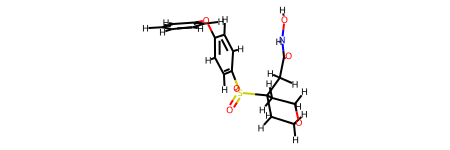

In [20]:
supplier[0]

In [25]:
assert len(lst_mol_names_raw) == len(lst_g1_raw)

In [26]:
### Make sure the order of PDB ids in two lists matches

for i1 in range(len(lst_mol_names_raw)):
    assert lst_mol_names_raw[i1].split('/')[-1] == lst_g1_raw[i1].split('/')[-1].split('_')[0]

## Data Sanity Check

ノードやエッジの次元が適切でないグラフが含まれています。これらのグラフをデータセットから削除します。

In [27]:
dataset_raw = MyDataset(lst_g1_raw)

In [28]:
lst_g1_updated = []
lst_mols_updated = []
lst_mol_names_updated = []
i_count = 0
for i0, g in enumerate(dataset_raw):
    if g[0][0].ndata['h'].shape[1] != 44 or \
        g[0][0].edata['e'].shape[1] != 5 or \
        g[0][1].edata['e'].shape[1] != 5 + len(args['distance_bins']): # This was fixed with PR 170
        i_count += 1
        print(i0, i_count, lst_g1_raw[i0])
    else:
        lst_g1_updated.append(lst_g1_raw[i0])
        lst_mols_updated.append(lst_mols_raw[i0])
        lst_mol_names_updated.append(lst_mol_names_raw[i0])

## Scaffold Split
各pdb_id を異なるデータセットに分割(train、val、test、または追加のホールドアウト) する csv ファイルを作成します。

### Bemis-Murcko Split を実行

In [29]:
dataset = MyDataset(lst_g1_updated)

In [30]:
scaffold_sets = ScaffoldSplitter.get_ordered_scaffold_sets(lst_mols_updated, 1000, 'decompose')

Start computing Bemis-Murcko scaffolds.
Computing Bemis-Murcko for compound 1000/5050
Computing Bemis-Murcko for compound 2000/5050
Computing Bemis-Murcko for compound 3000/5050
Computing Bemis-Murcko for compound 4000/5050
Computing Bemis-Murcko for compound 5000/5050


### Train - Val - Test Split

In [31]:
frac_train=0.60
frac_val=0.20
frac_test=0.20

train_indices, val_indices, test_indices = [], [], []
train_cutoff = int(frac_train * len(lst_mols_updated))
val_cutoff = int((frac_train + frac_val) * len(lst_mols_updated))
for group_indices in scaffold_sets:
    if len(train_indices) + len(group_indices) > train_cutoff:
        if len(train_indices) + len(val_indices) + len(group_indices) > val_cutoff:
            test_indices.extend(group_indices)
        else:
            val_indices.extend(group_indices)
    else:
        train_indices.extend(group_indices)

### Train - Val - Test - Holdout Split

In [32]:
frac_train=0.60
frac_val=0.10
frac_test=0.10
frac_finetune=0.20

train_indices, val_indices, test_indices, finetune_indices = [], [], [], []
train_cutoff = int(frac_train * len(lst_mols_updated))
val_cutoff = int((frac_train + frac_val) * len(lst_mols_updated))
test_cutoff = int((frac_train + frac_val + frac_test) * len(lst_mols_updated))

for group_indices in scaffold_sets:
    if len(train_indices) + len(group_indices) > train_cutoff:
        if len(train_indices) + len(val_indices) + len(group_indices) > val_cutoff:
            if len(train_indices) + len(val_indices) + len(test_indices) + len(group_indices) > test_cutoff:
                finetune_indices.extend(group_indices)
            else:
                test_indices.extend(group_indices)
        else:
            val_indices.extend(group_indices)
    else:
        train_indices.extend(group_indices)

In [33]:
lst_pdb_g1_bin_train = [lst_g1_updated[i].split('/')[-1] for i in train_indices]
lst_pdb_g1_bin_val = [lst_g1_updated[i].split('/')[-1] for i in val_indices]
lst_pdb_g1_bin_test = [lst_g1_updated[i].split('/')[-1] for i in test_indices]
lst_pdb_g1_bin_fine_tune = [lst_g1_updated[i].split('/')[-1] for i in finetune_indices]

In [34]:
lst_pdb_g1_bin_train2 = [{'g1_bin': pdb, 'split':'train'} for pdb in lst_pdb_g1_bin_train]
lst_pdb_g1_bin_val2 = [{'g1_bin': pdb, 'split':'val'} for pdb in lst_pdb_g1_bin_val]
lst_pdb_g1_bin_test2 = [{'g1_bin': pdb, 'split':'test'} for pdb in lst_pdb_g1_bin_test]
lst_pdb_g1_bin_fine_tune2 = [{'g1_bin': pdb, 'split':'fine_tune'} for pdb in lst_pdb_g1_bin_fine_tune]

lst_pdb_g1_bin2 = lst_pdb_g1_bin_train2 + lst_pdb_g1_bin_val2 + lst_pdb_g1_bin_test2 + lst_pdb_g1_bin_fine_tune2

pd.DataFrame(lst_pdb_g1_bin2).to_csv(f'Scaffold-Split-v2020-{len(lst_pdb_g1_bin2)}-files-tvtf.csv', index=False)

In [35]:
pd.DataFrame(lst_pdb_g1_bin2)

,g1_bin,split
0,1a99_g1.bin,train
1,1adl_g1.bin,train
2,1ado_g1.bin,train
3,1amk_g1.bin,train
4,1apv_g1.bin,train
...,...,...
5045,1a69_g1.bin,fine_tune
5046,1a4w_g1.bin,fine_tune
5047,1a4k_g1.bin,fine_tune
5048,1a1e_g1.bin,fine_tune


In [36]:
pd.read_csv(f'Scaffold-Split-v2020-{len(lst_pdb_g1_bin2)}-files-tvtf.csv')[pd.read_csv(f'Scaffold-Split-v2020-{len(lst_pdb_g1_bin2)}-files-tvtf.csv')['split'] == 'train']['g1_bin'].to_list()

['1a99_g1.bin',
 '1adl_g1.bin',
 '1ado_g1.bin',
 '1amk_g1.bin',
 '1apv_g1.bin',
 '1b05_g1.bin',
 '1b2h_g1.bin',
 '1b32_g1.bin',
 '1b3g_g1.bin',
 '1b3l_g1.bin',
 '1b4h_g1.bin',
 '1b4z_g1.bin',
 '1b51_g1.bin',
 '1b52_g1.bin',
 '1b57_g1.bin',
 '1b5h_g1.bin',
 '1b5i_g1.bin',
 '1b5j_g1.bin',
 '1b6h_g1.bin',
 '1b7h_g1.bin',
 '1b9j_g1.bin',
 '1bcd_g1.bin',
 '1d09_g1.bin',
 '1d7i_g1.bin',
 '1d7j_g1.bin',
 '1duv_g1.bin',
 '1ec9_g1.bin',
 '1ecq_g1.bin',
 '1egh_g1.bin',
 '1elr_g1.bin',
 '1ew8_g1.bin',
 '1ew9_g1.bin',
 '1f57_g1.bin',
 '1f73_g1.bin',
 '1f74_g1.bin',
 '1ft7_g1.bin',
 '1g74_g1.bin',
 '1g7v_g1.bin',
 '1g85_g1.bin',
 '1g98_g1.bin',
 '1grp_g1.bin',
 '1h2k_g1.bin',
 '1hmr_g1.bin',
 '1hms_g1.bin',
 '1hmt_g1.bin',
 '1hn4_g1.bin',
 '1hyo_g1.bin',
 '1i2s_g1.bin',
 '1ii5_g1.bin',
 '1iih_g1.bin',
 '1ik4_g1.bin',
 '1jaq_g1.bin',
 '1jcx_g1.bin',
 '1jet_g1.bin',
 '1jeu_g1.bin',
 '1kc7_g1.bin',
 '1koj_g1.bin',
 '1kv5_g1.bin',
 '1laf_g1.bin',
 '1lah_g1.bin',
 '1lan_g1.bin',
 '1lbk_g1.bin',
 '1lcp_g

In [37]:
import sagemaker
# Setup session
sess = sagemaker.Session()
your_bucket = sess.default_bucket()
prefix_ = 'kdd-graph-med' #e.g. prefix_ = 'tarai'

In [38]:
your_bucket_and_prefix = your_bucket + '/' + prefix_
your_bucket_and_prefix

'sagemaker-ap-northeast-1-233488627969/kdd-graph-med'

## S3へアップロード

### Upload core data

In [39]:
!aws s3 cp graph_files_v2020_core_13_withPDBID s3://{your_bucket}/preprocessed/graph_files_v2020_refined_core/ --recursive --exclude "*" --include "*.bin" --acl bucket-owner-full-control
    

upload: graph_files_v2020_core_13_withPDBID/1a30_g1.bin to s3://sagemaker-ap-northeast-1-233488627969/preprocessed/graph_files_v2020_refined_core/1a30_g1.bin
upload: graph_files_v2020_core_13_withPDBID/1bzc_g1.bin to s3://sagemaker-ap-northeast-1-233488627969/preprocessed/graph_files_v2020_refined_core/1bzc_g1.bin
upload: graph_files_v2020_core_13_withPDBID/1a30_g2.bin to s3://sagemaker-ap-northeast-1-233488627969/preprocessed/graph_files_v2020_refined_core/1a30_g2.bin
upload: graph_files_v2020_core_13_withPDBID/1bzc_g2.bin to s3://sagemaker-ap-northeast-1-233488627969/preprocessed/graph_files_v2020_refined_core/1bzc_g2.bin
upload: graph_files_v2020_core_13_withPDBID/1bcu_g1.bin to s3://sagemaker-ap-northeast-1-233488627969/preprocessed/graph_files_v2020_refined_core/1bcu_g1.bin
upload: graph_files_v2020_core_13_withPDBID/1e66_g2.bin to s3://sagemaker-ap-northeast-1-233488627969/preprocessed/graph_files_v2020_refined_core/1e66_g2.bin
upload: graph_files_v2020_core_13_withPDBID/1gpn_g1.

### Upload refined data

In [40]:
!aws s3 cp graph_files_v2020_refined_13_withPDBID s3://{your_bucket}/dgl-pdbbind/preprocessed/graph_files_v2020_refined_core/ --recursive --exclude "*" --include "*.bin" --acl bucket-owner-full-control
    

upload: graph_files_v2020_refined_13_withPDBID/184l_g1.bin to s3://sagemaker-ap-northeast-1-233488627969/dgl-pdbbind/preprocessed/graph_files_v2020_refined_core/184l_g1.bin
upload: graph_files_v2020_refined_13_withPDBID/187l_g1.bin to s3://sagemaker-ap-northeast-1-233488627969/dgl-pdbbind/preprocessed/graph_files_v2020_refined_core/187l_g1.bin
upload: graph_files_v2020_refined_13_withPDBID/10gs_g1.bin to s3://sagemaker-ap-northeast-1-233488627969/dgl-pdbbind/preprocessed/graph_files_v2020_refined_core/10gs_g1.bin
upload: graph_files_v2020_refined_13_withPDBID/1a1e_g1.bin to s3://sagemaker-ap-northeast-1-233488627969/dgl-pdbbind/preprocessed/graph_files_v2020_refined_core/1a1e_g1.bin
upload: graph_files_v2020_refined_13_withPDBID/186l_g1.bin to s3://sagemaker-ap-northeast-1-233488627969/dgl-pdbbind/preprocessed/graph_files_v2020_refined_core/186l_g1.bin
upload: graph_files_v2020_refined_13_withPDBID/10gs_g2.bin to s3://sagemaker-ap-northeast-1-233488627969/dgl-pdbbind/preprocessed/graph

### Upload the split instruction

In [ ]:
#!aws s3 cp Scaffold-Split-v2020-{len(lst_pdb_g1_bin2)}-files-tvtf.csv s3://{your_bucket}/dgl-pdbbind/preprocessed/graph_files_v2020_refined_core/Scaffold-Split-v2020-{len(lst_pdb_g1_bin2)}-files-tvtf.csv --acl bucket-owner-full-control
    

## Go to the second notebook : 2_train_potentialnet.ipynb

## (Optional) Pseudo fine tune dataset.

In [ ]:
df_fineTune = pd.DataFrame(lst_pdb_g1_bin2)[pd.DataFrame(lst_pdb_g1_bin2)['split'] != 'train']
df_fineTune

In [ ]:
df_fineTune[df_fineTune['split'] == 'fine_tune']['split'] = 'train'

In [ ]:
df_fineTune['split'] = df_fineTune['split'].replace('fine_tune', 'train')

In [ ]:
df_fineTune

In [ ]:
df_fineTune.to_csv(f'v2020-pseudo-fine-tune.csv', index=False)

In [ ]:
!aws s3 cp graph_files_v2020_core_13_withPDBID s3://'<your S3 prefix you want to upload the preprocessed PDBbind dataset>'/dgl-pdbbind/preprocessed/graph_files_v2020_fine_tune/ --recursive --exclude "*" --include "*.bin" --acl bucket-owner-full-control


In [ ]:
!aws s3 cp graph_files_v2020_general_13_withPDBID s3://'<your S3 prefix you want to upload the preprocessed PDBbind dataset>'/dgl-pdbbind/preprocessed/graph_files_v2020_fine_tune/ --recursive --exclude "*" --include "*.bin" --acl bucket-owner-full-control
    

In [ ]:
!aws s3 cp v2020-pseudo-fine-tune.csv s3://'<your S3 prefix you want to upload the preprocessed PDBbind dataset>'/dgl-pdbbind/preprocessed/graph_files_v2020_fine_tune/v2020-pseudo-fine-tune.csv --acl bucket-owner-full-control
